In [1]:
import os
import networkx as nx
import pandas as pd
import graspologic

data_dir = os.path.expanduser("~/Documents/Neural Data Design/cora")

In [2]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [3]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
Y = node_data.to_numpy()[:, 0:1433]
labels = node_data["subject"].to_numpy()

In [5]:
A = graspologic.utils.import_graph(Gnx)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(bbox_to_anchor=(1.5, 1), loc="upper right", title="Community")
    
    return plot

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


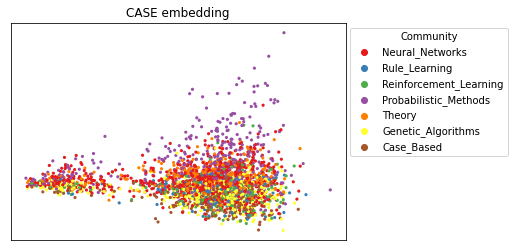

In [7]:
from graspologic.embed import CovariateAssistedEmbed as CASE

case = CASE(alpha=0.5, assortative=False, n_components=16)
latents = case.fit_transform((A, Y))
plot_latents(latents, title=r"CASE embedding", labels=labels);

## Train a classifier on CASE latent positions

In [27]:
from tensorflow.keras import layers, optimizers, losses, metrics, Model, Sequential, utils
from sklearn import preprocessing, model_selection

node_subjects = pd.Series(labels)
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)


train_data = latents[train_subjects.index.values, :]
test_data = latents[test_subjects.index.values, :]

## Create Keras model

In [35]:
model = Sequential(
    layers.Dense(units=train_targets.shape[1], activation="softmax")
)

In [36]:
model.compile(
    optimizer=optimizers.Adam(lr=0.05),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

## Train the model

In [37]:
model.fit(train_data, train_targets, epochs=100)

Epoch 1/100
60/60 [==============================] - 0s 532us/step - loss: 1.8061 - acc: 0.3058
Epoch 2/100
60/60 [==============================] - 0s 525us/step - loss: 1.5893 - acc: 0.4016
Epoch 3/100
60/60 [==============================] - 0s 501us/step - loss: 1.4224 - acc: 0.4799
Epoch 4/100
60/60 [==============================] - 0s 494us/step - loss: 1.2875 - acc: 0.6021
Epoch 5/100
60/60 [==============================] - 0s 494us/step - loss: 1.2085 - acc: 0.6212
Epoch 6/100
60/60 [==============================] - 0s 497us/step - loss: 1.1612 - acc: 0.6498
Epoch 7/100
60/60 [==============================] - 0s 503us/step - loss: 1.1175 - acc: 0.6538
Epoch 8/100
60/60 [==============================] - 0s 496us/step - loss: 1.0518 - acc: 0.6787
Epoch 9/100
60/60 [==============================] - 0s 499us/step - loss: 1.0261 - acc: 0.6941
Epoch 10/100
60/60 [==============================] - 0s 499us/step - loss: 1.0027 - acc: 0.6776
Epoch 11/100
60/60 [===================

## Evaluate the model

In [38]:
test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=2)

print('\nTest accuracy:', test_acc)

26/26 - 0s - loss: 0.8538 - acc: 0.7171

Test accuracy: 0.7170971632003784


## Make prediction for all the nodes

In [39]:
all_predictions = model.predict(latents)

In [40]:
node_predictions = target_encoding.inverse_transform(all_predictions)

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


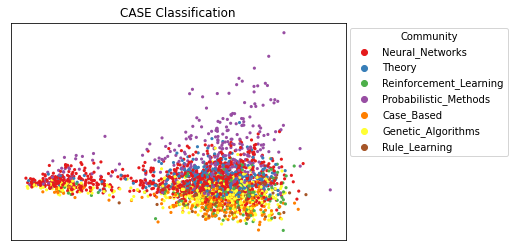

In [41]:
plot_latents(latents, title=r"CASE Classification", labels=node_predictions);

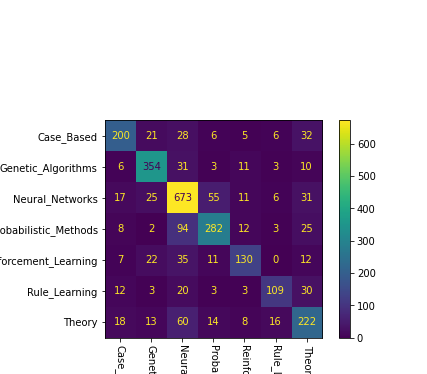

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, node_predictions, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))
disp.plot(xticks_rotation=270)